# Setup

In [42]:
import subprocess
import sys

def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = [
    "os", "base64", "requests", "json", "pandas", "python-dotenv", "numpy",
    "seaborn", "scikit-learn", "matplotlib", "xgboost"
]

for package in packages:
    install_and_import(package)

import os
import base64
from requests import post, get
import json
import pandas as pd
from dotenv import load_dotenv
import numpy as np
from functools import cache
import time

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [43]:
load_dotenv()
client_id = os.getenv("CLIENT_ID1")
client_secret = os.getenv("CLIENT_SECRET1")
print(client_id)

8ff9af25d5c54f06b14de2a315c01cbd


In [44]:

def get_token():
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data={
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret,
    }

    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    return json_result['access_token']

def get_auth_header(token):
    return {
        "Authorization": "Bearer " + token,
    }


In [45]:
def reset_token(number):
    global client_id, client_secret,token,header
    client_id = os.getenv(f"CLIENT_ID{number}")
    client_secret = os.getenv(f"CLIENT_SECRET{number}")
    token = get_token()
    header = get_auth_header(token)


In [46]:
token = get_token()
header = get_auth_header(token)
print(token)


BQB8yzfPDAm74KbaliU4kIrtSitCA-DIAxDI-hJCTnTAEYmxBnsvy_9hL61Wp4KbYE_xHk4xGG73--GpaQMjVSQz31YFkzq-kKJJNd2z6TKKPTDG3LA


## ALBUM

In [47]:
def get_album(album_id, market=None):
    """
    Get Spotify catalog information for a single album.

    Parameters:
    - album_id (str): The Spotify ID of the album.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.

    Returns:
    - dict: JSON response containing the album's information.
    """
    url = f"https://api.spotify.com/v1/albums/{album_id}"
    headers = header
    params = {}

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_several_albums(album_ids, market=None):
    """
    Get Spotify catalog information for multiple albums identified by their Spotify IDs.

    Parameters:
    - album_ids (list): A list of Spotify IDs for the albums. Maximum: 20 IDs.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.

    Returns:
    - dict: JSON response containing the albums' information.
    """
    url = "https://api.spotify.com/v1/albums"
    headers = header
    params = {
        "ids": ",".join(album_ids)
    }

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_album_tracks(album_id, market=None, limit=20, offset=0):
    """
    Get Spotify catalog information about an album’s tracks.

    Parameters:
    - album_id (str): The Spotify ID of the album.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - limit (int, optional): The maximum number of items to return. Default is 20. Range is 1 to 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the album's tracks information.
    """
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

## ARTIST

In [48]:
def get_artist(artist_id):
    """
    Get Spotify catalog information for a single artist.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.

    Returns:
    - dict: JSON response containing the artist's information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}"
    headers = header

    response = get(url, headers=headers)
    return response.json()

def get_several_artists(artist_ids):
    """
    Get Spotify catalog information for several artists based on their Spotify IDs.

    Parameters:
    - artist_ids (list): A list of Spotify IDs for the artists. Maximum: 50 IDs.

    Returns:
    - dict: JSON response containing the artists' information.
    """
    url = "https://api.spotify.com/v1/artists"
    headers = header
    params = {
        "ids": ",".join(artist_ids)
    }

    response = get(url, headers=headers, params=params)
    return response.json()

def get_artist_albums(artist_id, include_groups=None, market=None, limit=20, offset=0):
    """
    Get Spotify catalog information about an artist's albums.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.
    - include_groups (str, optional): A comma-separated list of keywords to filter the response. Valid values are "album", "single", "appears_on", "compilation".
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - limit (int, optional): The maximum number of items to return. Default is 20. Range is 1 to 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the artist's albums information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if include_groups:
        params["include_groups"] = include_groups
    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_artist_top_tracks(artist_id, market=None):
    """
    Get Spotify catalog information about an artist's top tracks by country.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.

    Returns:
    - dict: JSON response containing the artist's top tracks information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks"
    headers = header
    params = {}

    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()

def get_related_artists(artist_id):
    """
    Get Spotify catalog information about artists similar to a given artist.

    Parameters:
    - artist_id (str): The Spotify ID of the artist.

    Returns:
    - dict: JSON response containing the related artists' information.
    """
    url = f"https://api.spotify.com/v1/artists/{artist_id}/related-artists"
    headers = header

    response = get(url, headers=headers)
    return response.json()

## CATEGORIES

In [49]:
def get_categories(locale=None, limit=20, offset=0):
    """
    Get a list of categories used to tag items in Spotify (on, for example, the Spotify player’s “Browse” tab).

    Parameters:
    - locale (str, optional): The desired language, consisting of an ISO 639-1 language code and an ISO 3166-1 alpha-2 country code, joined by an underscore.
    - limit (int, optional): The maximum number of items to return. Default is 20. Minimum is 1. Maximum is 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the categories information.
    """
    url = "https://api.spotify.com/v1/browse/categories"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if locale:
        params["locale"] = locale

    response = get(url, headers=headers, params=params)
    return response.json()

def get_single_browse_category(category_id, locale=None):
    """
    Get a single category used to tag items in Spotify.

    Parameters:
    - category_id (str): The Spotify category ID for the category.
    - locale (str, optional): The desired language, consisting of an ISO 639-1 language code and an ISO 3166-1 alpha-2 country code, joined by an underscore.

    Returns:
    - dict: JSON response containing the category's information.
    """
    url = f"https://api.spotify.com/v1/browse/categories/{category_id}"
    headers = header
    params = {}

    if locale:
        params["locale"] = locale

    response = get(url, headers=headers, params=params)
    return response.json()

## PLAYLIST

In [50]:

def get_playlist(playlist_id, market=None, fields=None, access_token=None):
    """
    Get a playlist owned by a Spotify user.

    Parameters:
    - playlist_id (str): The Spotify ID of the playlist.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - fields (str, optional): Filters for the query, a comma-separated list of the fields to return.
    - access_token (str, optional): A valid user access token.

    Returns:
    - dict: JSON response containing the playlist information.
    """
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}"
    headers = header
    params = {}

    if market:
        params["market"] = market
    if fields:
        params["fields"] = fields

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        response.raise_for_status()  # Raise an error for bad responses

def get_playlist_items(playlist_id, market=None, fields=None, limit=20, offset=0, additional_types=None):
    """
    Get full details of the items of a playlist owned by a Spotify user.

    Parameters:
    - playlist_id (str): The Spotify ID of the playlist.
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - fields (str, optional): Filters for the query.
    - limit (int, optional): The maximum number of items to return. Default is 20. Range is 1 to 50.
    - offset (int, optional): The index of the first item to return. Default is 0.
    - additional_types (str, optional): A comma-separated list of item types that your client supports besides the default track type.

    Returns:
    - dict: JSON response containing the playlist items' information.
    """
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if market:
        params["market"] = market
    if fields:
        params["fields"] = fields
    if additional_types:
        params["additional_types"] = additional_types

    response = get(url, headers=headers, params=params)
    return response.json()

def get_playlist_track_ids(playlist_id, limit=100, offset=0):
    """
    Get only the track IDs from a Spotify playlist.

    Parameters:
    - playlist_id (str): The Spotify ID of the playlist.
    - access_token (str): A valid user access token.
    - limit (int, optional): The maximum number of tracks to return. Default is 100.
    - offset (int, optional): The index of the first track to return. Default is 0.

    Returns:
    - list: A list of track IDs from the playlist.
    """
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = header
    params = {
        "fields": "items(track(id))",
        "limit": limit,
        "offset": offset
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        # Extrair apenas os IDs das faixas
        track_ids = [item['track']['id'] for item in data['items'] if item['track']]
        return track_ids
    else:
        response.raise_for_status()  # Raise an error for bad responses

def get_featured_playlists(locale=None, limit=20, offset=0):
    """
    Get a list of Spotify featured playlists.

    Parameters:
    - locale (str, optional): The desired language, consisting of an ISO 639-1 language code and an ISO 3166-1 alpha-2 country code, joined by an underscore.
    - limit (int, optional): The maximum number of items to return. Default is 20. Minimum is 1. Maximum is 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the featured playlists information.
    """
    url = "https://api.spotify.com/v1/browse/featured-playlists"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    if locale:
        params["locale"] = locale

    response = get(url, headers=headers, params=params)
    return response.json()

def get_category_playlists(category_id, limit=20, offset=0):
    """
    Get a list of Spotify playlists tagged with a particular category.

    Parameters:
    - category_id (str): The Spotify category ID for the category.
    - limit (int, optional): The maximum number of items to return. Default is 20. Minimum is 1. Maximum is 50.
    - offset (int, optional): The index of the first item to return. Default is 0.

    Returns:
    - dict: JSON response containing the playlists information.
    """
    url = f"https://api.spotify.com/v1/browse/categories/{category_id}/playlists"
    headers = header
    params = {
        "limit": limit,
        "offset": offset
    }

    response = get(url, headers=headers, params=params)
    return response.json()

import requests


## SEARCH

In [51]:
def search_spotify_items(q, types, market=None, limit=20, offset=0, include_external=None):
    """
    Search for Spotify catalog information about albums, artists, playlists, tracks, shows, episodes, or audiobooks.

    Parameters:
    - q (str): The search query.
    - types (list): A list of item types to search across. Allowed values: "album", "artist", "playlist", "track", "show", "episode", "audiobook".
    - market (str, optional): An ISO 3166-1 alpha-2 country code.
    - limit (int, optional): The maximum number of results to return in each item type. Default is 20. Range is 0 - 50.
    - offset (int, optional): The index of the first result to return. Default is 0. Range is 0 - 1000.
    - include_external (str, optional): If "audio", includes externally hosted audio content as playable.

    Returns:
    - dict: JSON response containing the search results.
    """
    base_url = "https://api.spotify.com/v1/search"
    headers = header
    params = {
        "q": q,
        "type": ",".join(types),
        "limit": limit,
        "offset": offset
    }

    if market:
        params["market"] = market
    if include_external:
        params["include_external"] = include_external

    response = get(base_url, headers=headers, params=params)
    return response.json()

## TRACKS


In [52]:
def get_several_tracks_info(ids, market=None):
    """
    Get detailed Spotify catalog information for multiple tracks based on their Spotify IDs.

    Parameters:
    - ids (list of str): List of Spotify track IDs. Maximum is 50 IDs.
    - market (str, optional): An ISO 3166-1 alpha-2 country code. Only content available in this market will be returned.

    Returns:
    - dict: JSON response containing track information.
    """
    if len(ids) > 100:
        raise ValueError("The maximum number of track IDs is 50.")

    url = "https://api.spotify.com/v1/tracks"
    headers = header
    params = {
        "ids": ",".join(ids)
    }
    if market:
        params["market"] = market

    response = get(url, headers=headers, params=params)
    return response.json()




def get_several_tracks_audio_features(ids):
    """
    Get audio features for multiple tracks based on their Spotify IDs.

    Parameters:
    - ids (list of str): List of Spotify track IDs. Maximum is 100 IDs.

    Returns:
    - dict: JSON response containing the audio features information.
    """
    if len(ids) > 100:
        raise ValueError("The maximum number of track IDs is 100.")

    url = "https://api.spotify.com/v1/audio-features"
    headers = header
    params = {
        "ids": ",".join(ids)
    }

    response = get(url, headers=headers, params=params)
    return response.json()



# Trabalho

### DEFININDO GENEROS

In [53]:
categories = {
    "names": [],
    "ids": []
}

categories_data = get_categories( limit=50, offset=0)['categories']['items']
names = np.array([category['name'] for category in categories_data])
ids = np.array([category['id'] for category in categories_data])

# Efficiently assign lists without a loop
categories["names"] = names.tolist()
categories["ids"] = ids.tolist()
categories

{'names': ['Made For You',
  'New Releases',
  'Marília Mendonça',
  'Brazil',
  'Sertanejo',
  'Pop',
  'Charts',
  'Brazilian Funk',
  'In the car',
  'Hip-Hop',
  'Samba & Pagode',
  'Discover',
  'MPB',
  'AMPLIFIKA',
  'Dance/Electronic',
  'Christian & Gospel',
  'Rock',
  'Indie',
  'RADAR',
  'GLOW',
  'EQUAL',
  'Mood',
  'Workout',
  'Chill',
  'Party',
  'At Home',
  'Sleep',
  'Love',
  'Cooking & Dining',
  'Wellness',
  'Focus',
  'Trending',
  'Decades',
  'Spotify Singles',
  'Cities',
  'Travel',
  'Nature & Noise',
  'Latin',
  'R&B',
  'K-pop',
  'Songwriters',
  'Music + Talk',
  'Fresh Finds',
  'Kids & Family',
  'TV & Movies',
  'Gaming',
  'Anime',
  'Tastemakers',
  'Netflix',
  'Student'],
 'ids': ['0JQ5DAt0tbjZptfcdMSKl3',
  '0JQ5DAqbMKFz6FAsUtgAab',
  '0JQ5DAqbMKFNN285FvRwOf',
  '0JQ5DAqbMKFKGQWi5egawY',
  '0JQ5DAqbMKFJCTDO6ndZMP',
  '0JQ5DAqbMKFEC4WFtoNRpw',
  '0JQ5DAudkNjCgYMM0TZXDw',
  '0JQ5DAqbMKFCkm2Enfbj7Y',
  '0JQ5DAqbMKFIRybaNTYXXy',
  '0JQ5DAqbMKFQ0

In [54]:

categories_df = pd.DataFrame(categories)
#categories_df = categories_df[categories_df['names'].isin(filter_categories)]
#categories_df = categories_df.reset_index(drop=True)
categories_df.head()

,names,ids
0,Made For You,0JQ5DAt0tbjZptfcdMSKl3
1,New Releases,0JQ5DAqbMKFz6FAsUtgAab
2,Marília Mendonça,0JQ5DAqbMKFNN285FvRwOf
3,Brazil,0JQ5DAqbMKFKGQWi5egawY
4,Sertanejo,0JQ5DAqbMKFJCTDO6ndZMP


In [55]:
#Removendo as 3 primeiras linhas
categories_df = categories_df.iloc[3:]


### Buscando playlist


In [56]:
import concurrent.futures

# Inicializando o dicionário
playlists = {
    "ids": [],
    "messages": [],
}

# Função auxiliar para extrair IDs e mensagens
def extract_ids_and_messages(track_collection):
    items = track_collection['playlists']['items']
    message = track_collection['message']
    return [(item['id'], message) for item in items]

# Executando a função de forma concorrente
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Obtém as playlists para cada categoria em threads
    playlists_data = list(executor.map(lambda item: get_category_playlists(item, limit=50, offset=0), categories_df['ids']))
    
    # Extrai os dados de cada playlist de forma concorrente
    extracted_data = list(executor.map(extract_ids_and_messages, playlists_data))

# Adicionando IDs e mensagens ao dicionário
for data in extracted_data:
    for playlist_id, message in data:
        playlists["ids"].append(playlist_id)
        playlists["messages"].append(message)


In [57]:
playlists_df=pd.DataFrame(playlists)
playlists_df

,ids,messages
0,37i9dQZF1DX0FOF1IUWK1W,Brazil
1,37i9dQZF1DXdSjVZQzv2tl,Brazil
2,37i9dQZF1DWVjNkaVEkL3X,Brazil
3,37i9dQZF1DWTkIwO2HDifB,Brazil
4,37i9dQZF1DXcedEPj5nsZ0,Brazil
...,...,...
1613,37i9dQZF1DXd2wJvXxyJb8,Student
1614,37i9dQZF1DWTf69iQOGkD2,Student
1615,37i9dQZF1DX0H97kz3DdJ6,Student
1616,37i9dQZF1DWWr5uieiPUVM,Student


In [58]:
def list_value_counts_less_than(playlists_df, num=50):
    value_counts = playlists_df.value_counts()
    messages_less_than = value_counts[value_counts < num]
    return messages_less_than

def list_value_counts_more_than(playlists_df, num=50):
    value_counts = playlists_df.value_counts()
    messages_more_than = value_counts[value_counts > num]
    return messages_more_than

In [59]:
#exibe as messages que tem menos de 50 playlists message value counts
messages_less_than_50 =list_value_counts_less_than(playlists_df['messages'],50)
len(messages_less_than_50)

29

In [60]:
to_50 = {
    "ids": [],
    "number_to_50": [],
}

for item in messages_less_than_50.index:
    category_id = categories_df.loc[categories_df['names'] == item, 'ids'].values[0]
    number_to_50=50-messages_less_than_50[item]
    to_50["ids"].append(category_id)
    to_50["number_to_50"].append(number_to_50)

    

In [61]:
from concurrent.futures import ThreadPoolExecutor

def fetch_playlists(item, limit, offset):
    return get_category_playlists(item, limit=limit, offset=offset)

def extract_data(data):
    return extract_ids_and_messages(data)

playlists_data = []
extracted_data = []

with ThreadPoolExecutor() as executor:
    for i in [1, 2, 3]:
        # Obtém as playlists para cada categoria
        playlists_data.extend(executor.map(fetch_playlists, to_50['ids'], [to_50['number_to_50']] * len(to_50['ids']), [i] * len(to_50['ids'])))
    
    # Extrai os dados de cada playlist
    extracted_data.extend(executor.map(extract_data, playlists_data))

# Adicionando IDs e mensagens ao dicionário
for data in extracted_data:
    for playlist_id, message in data:
        playlists["ids"].append(playlist_id)
        playlists["messages"].append(message)

In [62]:

playlists_df=pd.DataFrame(playlists)
playlists_df.messages.value_counts()


messages
AMPLIFIKA             54
Latin                 52
Rock                  50
Hip-Hop               50
Christian & Gospel    50
Focus                 50
Sleep                 50
Love                  50
Wellness              50
Mood                  50
Party                 50
EQUAL                 50
Brazil                50
Songwriters           50
K-pop                 50
Nature & Noise        50
Anime                 50
At Home               50
Tastemakers           46
Samba & Pagode        46
Pop                   45
RADAR                 44
Chill                 43
Workout               42
Charts                42
Sertanejo             40
Brazilian Funk        40
GLOW                  37
R&B                   36
Netflix               36
Indie                 36
Kids & Family         35
Trending              34
TV & Movies           34
MPB                   33
Dance/Electronic      29
Fresh Finds           27
Gaming                26
Cooking & Dining      26
Student         

In [63]:
#remove todas as linhas em que value counts message for menor que 40

messages_less_than_40 = list_value_counts_less_than(playlists_df['messages'],40)
#remove todas as messages de playlists_df que estiverem em messages_less_than_40
playlists_df = playlists_df[~playlists_df['messages'].isin(messages_less_than_40.index)]

In [64]:
more_than_50 = list_value_counts_more_than(playlists_df['messages'],50)
more_than_50

# Function to remove excess rows
def remove_excess_rows(df, message, excess_count):
    indices_to_remove = df[df['messages'] == message].index[:excess_count]
    return df.drop(indices_to_remove)

# Remove excess rows for each message
for message, count in more_than_50.items():
    excess_count = count - 50
    playlists_df = remove_excess_rows(playlists_df, message, excess_count)

# Reset index after removal
playlists_df = playlists_df.reset_index(drop=True)

In [65]:
playlists_df

,ids,messages
0,37i9dQZF1DX0FOF1IUWK1W,Brazil
1,37i9dQZF1DXdSjVZQzv2tl,Brazil
2,37i9dQZF1DWVjNkaVEkL3X,Brazil
3,37i9dQZF1DWTkIwO2HDifB,Brazil
4,37i9dQZF1DXcedEPj5nsZ0,Brazil
...,...,...
1283,37i9dQZEVXbLiRSasKsNU9,Charts
1284,37i9dQZF1DX3R59Eoqqsy8,Sertanejo
1285,37i9dQZF1DWXeSNtpjKSsO,Sertanejo
1286,37i9dQZF1DWSlRNWoWejBr,Brazilian Funk


In [66]:
playlists_ids = playlists_df['ids'].tolist()

In [67]:
playlists_ids

['37i9dQZF1DX0FOF1IUWK1W',
 '37i9dQZF1DXdSjVZQzv2tl',
 '37i9dQZF1DWVjNkaVEkL3X',
 '37i9dQZF1DWTkIwO2HDifB',
 '37i9dQZF1DXcedEPj5nsZ0',
 '37i9dQZF1DX0OEZC3cbQmU',
 '37i9dQZF1DWVPifjQJoRjt',
 '37i9dQZF1DX5lAV5ZGu9ik',
 '37i9dQZF1DX34KNiFQJNVm',
 '37i9dQZF1DX03VbhoH7arm',
 '37i9dQZF1DWXFLyAKm1KMY',
 '37i9dQZF1DXcedEPj5nsZ0',
 '37i9dQZF1DXcCxkJNppBVW',
 '37i9dQZF1DX3vtb4am50ft',
 '37i9dQZF1DWVzWEsonvUyr',
 '37i9dQZF1DX0Mv9kGvSKmv',
 '37i9dQZF1DWTo645rcXEVL',
 '37i9dQZF1DX1JLGl05i0Pq',
 '37i9dQZF1DXbkU0pC52xDz',
 '37i9dQZF1DXdXbKzsf80lE',
 '37i9dQZF1DWVBWFXlHC6s7',
 '37i9dQZF1DXdOhsna07Pvz',
 '37i9dQZF1DX94Xc0f4tUlY',
 '37i9dQZF1DWWaKvg3kI2zN',
 '37i9dQZF1DWU5TxeYcalut',
 '37i9dQZF1DX37tPhuSLdTj',
 '37i9dQZF1DX173i0mw3gHN',
 '37i9dQZF1DX6EQe4DjJNfI',
 '37i9dQZF1DX1Ik4Vw9v7ar',
 '37i9dQZF1DX5w1M5Q5bm0S',
 '37i9dQZF1DWWaKvg3kI2zN',
 '37i9dQZF1DX7f8PyAQL3rz',
 '37i9dQZF1DX9bElHbSmruB',
 '37i9dQZF1DX95vhptNy3YE',
 '37i9dQZF1DX2vsux22VuNL',
 '37i9dQZF1DX5R53BjnKBjk',
 '37i9dQZF1DXd2wJvXxyJb8',
 

## Spotpy


In [68]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import re

In [69]:
# leaving these public because there's no need to make env-vars
cid = "e19f868c40394ceeb90e778daf20f9c7"
secret = "6be8e17dfbe347f0976fbdf00f500bc9"

In [70]:
# Authentication - without user
client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, client_secret=client_secret
)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [71]:
playlists_ids_test = playlists_ids[:3]
playlists_ids_test.append('37i9dQZF1EZT8cSzhJA9lL')
playlists_ids_test.extend(playlists_ids[5:9])
playlists_ids_test

['37i9dQZF1DX0FOF1IUWK1W',
 '37i9dQZF1DXdSjVZQzv2tl',
 '37i9dQZF1DWVjNkaVEkL3X',
 '37i9dQZF1EZT8cSzhJA9lL',
 '37i9dQZF1DX0OEZC3cbQmU',
 '37i9dQZF1DWVPifjQJoRjt',
 '37i9dQZF1DX5lAV5ZGu9ik',
 '37i9dQZF1DX34KNiFQJNVm']

In [72]:
len(playlists_ids)

1288

In [73]:
def get_tracks_ids (info):
    track_ids = []
    for info_item in info:
        if info_item['tracks'] and info_item['tracks']['items']:
            for item in info_item['tracks']['items']:
                if item and item['track']:
                    track_ids.append(item['track']['id'])
    return track_ids

In [74]:
def get_playlist_info(playlists_df):
    playlist_info = {
        "ids": [],
        "message": [],
    }
    playlists_ids = playlists_df['ids'].tolist()
    messages = playlists_df['messages'].tolist()
    
    for idx, playlist_id in enumerate(playlists_ids):
        response=get_playlist_track_ids(playlist_id)
        
        playlist_info["ids"].extend(response)  # Adiciona todos os IDs de uma vez
        playlist_info["message"].extend([messages[idx]] * len(response))  # Repete a mensagem para cada item em response
        
    return playlist_info


In [75]:
import functools
import concurrent.futures

# Apply caching to get_playlist_track_ids
def get_tracks_ids(info):
    track_ids = []
    for info_item in info:
        items = info_item.get('tracks', {}).get('items', [])
        for item in items:
            track_id = item.get('track', {}).get('id')
            if track_id:
                track_ids.append(track_id)
    return track_ids
@functools.lru_cache(maxsize=None)
def get_playlist_info(playlists_df):
    playlist_info = {
        "ids": [],
        "message": [],
    }
    playlists_ids = playlists_df['ids'].tolist()
    messages = playlists_df['messages'].tolist()

    def fetch_playlist_data(idx):
        playlist_id = playlists_ids[idx]
        for number in range(11):  # Try numbers from 0 to 10
            try:
                response = get_playlist_track_ids(playlist_id)
                return response, messages[idx]
            except Exception:
                reset_token(number)
        # If all retries fail, return [], messages[idx]
        return [], messages[idx]

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(fetch_playlist_data, range(len(playlists_ids))))

    for response, message in results:
        playlist_info["ids"].extend(response)
        playlist_info["message"].extend([message] * len(response))

    return playlist_info

In [76]:
if not os.path.exists('track_ids.csv'):
    try:
        playlist_info=get_playlist_info(playlists_df)
    except Exception:
        print(f"Erro ao concluir aguarde 4min e execute denovo garant que o .env esta completo: {Exception}")
else:
    print("Arquivo existente usando track_ids.csv local")
    playlist_info = pd.read_csv('track_ids.csv')

Arquivo existente usando track_ids.csv local


In [180]:
track_ids_df=pd.DataFrame(playlist_info)

In [166]:
if not os.path.exists('track_ids.csv'):
    track_ids_df.to_csv('track_ids.csv', index=False)
    print("Arquivo criado")
else:
    print("Arquivo ja existe")


Arquivo ja existe


In [181]:
#inverter a ordem dos de message com ids
track_ids_df = track_ids_df[['message', 'ids']]
track_ids_df

,message,ids
0,Brazil,6s1kzj4EbhFLXbuAGJbhbn
1,Brazil,1YlfGwNizEKy299l1PVggn
2,Brazil,1wubETHu3SeJHfbz9itEH0
3,Brazil,3JLhwgadVkN8zckxL1ICrI
4,Brazil,7l9Tq5phzkLnhWUyfp702G
...,...,...
118078,TV & Movies,4QDlcd4wAmmXXtKryfTxnO
118079,TV & Movies,7kWZqFgngoi8c3Bbjh3Csr
118080,TV & Movies,2wdRWIsv9QnDFO9trsniXw
118081,TV & Movies,0hqh8M4ttzlNsQYHlIeEhr


In [182]:
track_ids_df.ids.value_counts()

ids
2plbrEY59IikOBgBGLjaoe    66
5vNRhkKd0yEAg8suGBpjeY    61
6dOtVTDdiauQNBQEDOtlAB    52
3H7eBmcTJyuEMStfmKuLmG    47
0WbMK4wrZ1wFSty9F7FCgu    46
                          ..
6ajRRfc2LHpk9Ln8tKIrf5     1
2j2CXR4lLqP8YqGdc7bosZ     1
3o9Yhvfzz2M7vpznPrCmFi     1
4ghT12J2hsyfn0JZ4RDWrf     1
2dR5WkrpwylTuT3jRWNufa     1
Name: count, Length: 55095, dtype: int64

In [183]:
#remove ids duplicados e nulos e reseta o index
track_ids_df = track_ids_df.drop_duplicates(subset=['ids']).dropna().reset_index(drop=True)
track_ids_df

,message,ids
0,Brazil,6s1kzj4EbhFLXbuAGJbhbn
1,Brazil,1YlfGwNizEKy299l1PVggn
2,Brazil,1wubETHu3SeJHfbz9itEH0
3,Brazil,3JLhwgadVkN8zckxL1ICrI
4,Brazil,7l9Tq5phzkLnhWUyfp702G
...,...,...
55090,Latin,2QpmB0XYs7ndRfCC2Setb7
55091,Latin,0BiDnJFB3TlRB6aji7jUz3
55092,Latin,1w0nTizRgdMsoFwGAYhqRg
55093,Latin,587pEvJ7iJhNtcCf5YKEgE


In [185]:


def group_ids_by_message_to_df(df):
    rows = []
    for message, group in df.groupby('message'):
        ids = group['ids'].tolist()
        for i in range(0, len(ids), 100):
            rows.append({'message': message, 'ids': ids[i:i+100]})
    return pd.DataFrame(rows)

# Chamada da função
track_ids_df_filled = group_ids_by_message_to_df(track_ids_df)

# Exibir o resultado
track_ids_df_filled


,message,ids
0,AMPLIFIKA,"[7pv80uUHfocFqfTytu1MVi, 0tNuJpBgtE65diL6Q8Q7f..."
1,AMPLIFIKA,"[7MGNHuYwmm9UjQgdVciO1v, 02SUyCzxfqllXeEUqVNMV..."
2,AMPLIFIKA,"[1AleFCcNYQNC7T0GMqSsgT, 2TNzOZHh1Q3sJOgI10DSC..."
3,AMPLIFIKA,"[3TN15iCdD9W0smh4cujE67, 3xhzb5GcaC4msD1JZmNyL..."
4,AMPLIFIKA,"[4oNnEtS6QgwT8Co9P9TAVC, 1nUlMrFnHfRl3oJ4ZMt5X..."
...,...,...
565,Workout,"[0d28khcov6AiegSCpG5TuT, 0O45fw2L5vsWpdsOdXwNA..."
566,Workout,"[48QmG1dfvMuYLxMPt7KSRA, 0qt5f5EL92o8Snzopsv0e..."
567,Workout,"[1LHZMWefF9502NPfArRfvP, 4D01oA1mGouaAT7fubvKR..."
568,Workout,"[7LTCmtMpf3JPfBE8gAl64z, 1YDebgap5OFwXEBG18NJv..."


In [186]:
len(track_ids_df_filled['message'].unique())==len(track_ids_df['message'].unique())

True

In [214]:
#mudar o nome de ids para track_ids
track_ids_df_filled = track_ids_df_filled.rename(columns={'ids': 'track_ids'})

In [213]:
for i, ids in enumerate(track_ids_df_filled.ids):
    if len(ids)>100:
        track_ids = track_ids_df_filled['track_ids'][i]
        print(f"Ids: {",".join(track_ids)} Tamanho: {len(track_ids)} Erro no Index: {i} ")

In [216]:

track_ids = track_ids_df_filled['track_ids'][0]
print(len(track_ids),",".join(track_ids))

100 7pv80uUHfocFqfTytu1MVi,0tNuJpBgtE65diL6Q8Q7fI,6zfVYM5Nne0EzpjzYfJKwp,3F3PuqGinS2T1ePmjUTw9t,2jAn0rAOyLW6hIEuIDNcoT,2vLwhcsvRd1f2ETft1kWDN,74HYrIbnpc2xKCTenv5qKM,7LJz6DZS1tIRB06bbYbAPi,6sIMSl1n3KDPr03Fw8mujd,2W9FCvuxSSXbnkj9q4Dd9N,44BRidSOFkXcKH3oZzHKdR,7BgUcOjSOlKJXASLgJ6bx1,6s4xndGKUhW0xXPYvFlwcL,7e0j6jReCfN5KJkDNLHyHQ,0QQDaKW7eRRoqvbLCylzrn,79UjqYt9MCLlBpzAvaKVJj,15QJXeFMsil7J8hHWaC8Ma,7otmKWoMlpWkrMnnIQHXEg,2mOKh7J2mRrdnkHhqpHwFj,1GoTvQP3JEeA8oh5I9b2xc,2ESN3ebvvqXcFAMxxn6QXF,5GsT7Z8h4PL3TPtWm3Maki,1MCem6JigI6jgQPMgriKbU,5dlfvkyZOuBCFP1KbzRHUx,5jSMRqsK70fjBAqZMJ6uCI,5v1SuYGd6VFMGu8nVHzajO,58yWJFglBzvZ7Zao70lGtJ,6zSe7ZKNjb6Zl5AP78y5QN,6zi8kGpTadjpsLCO4jvMsH,7fRPY74Uk27yrTj1oYUFAj,6PMb77Py549WyGEDJNAacT,1rqduvolf1CVHSzY519bPp,5rI0lmvmena4CW3C4zwZ4v,0ieS2bue78yadTdPiyzsaO,3nSECoLmCiUbpQVJtpmS1I,1LljLapsjkl6sXsLwZzI73,6t7SsmMEWNNJaFEpIjrYop,0ZKCq8E5QS4lRjEtFvZqZX,2z4ypE6YI1mybsczNx4eRU,3aapF0aOexc3GMvVuu2Wdw,3HW030T8eqPs8wpsgZqCGM,5pBJR2HRrgBrvcL7Tf33xi,20RTW1RVNY4B2uUo2MrFTg,7DChMyO

In [217]:
track_features_response=get_several_tracks_audio_features(track_ids_df_filled['track_ids'][0][:3])
track_features_response

{'error': {'status': 429}}

In [91]:
track_features_response["audio_features"][2]['danceability']

0.443

In [ ]:
reset_token(666)


BQBWoVChwg2wMk78mylT0JBB-7gMDd9Eii8v-ZAfq4UiC-HnjpynA0yJfQAXt-19gAyby9kbB4z-LuWYinUS2DkakhuCt1ltlpAotKo37hrTGJMr2VI


In [105]:
#TODO: melhorar/otimizar o código

# Inicializa o dicionário para armazenar as características das faixas
track_features = {
    "danceability": [],
    "energy": [],
    "key": [],
    "loudness": [],
    "mode": [],
    "speechiness": [],
    "acousticness": [],
    "instrumentalness": [],
    "liveness": [],
    "valence": [],
    "tempo": [],
    "duration_ms": [],
    "time_signature": [],
    "category": []
}

# Função auxiliar para processar uma linha do DataFrame
def process_track_features(index):
    try:
        features = get_several_tracks_audio_features(track_ids_df_filled['track_ids'][index])
        
        if 'audio_features' not in features:
            print(f"Audio features not found for index {index}.")
            return {k: [] for k in track_features}  # Retorne uma linha vazia
        
        row_features = {k: [] for k in track_features}
        
        for track in features['audio_features']:
            row_features["danceability"].append(track["danceability"])
            row_features["energy"].append(track["energy"])
            row_features["key"].append(track["key"])
            row_features["loudness"].append(track["loudness"])
            row_features["mode"].append(track["mode"])
            row_features["speechiness"].append(track["speechiness"])
            row_features["acousticness"].append(track["acousticness"])
            row_features["instrumentalness"].append(track["instrumentalness"])
            row_features["liveness"].append(track["liveness"])
            row_features["valence"].append(track["valence"])
            row_features["tempo"].append(track["tempo"])
            row_features["duration_ms"].append(track["duration_ms"])
            row_features["time_signature"].append(track["time_signature"]) 
            row_features["category"].append(track_ids_df_filled['message'][index])
        
        return row_features
    
    except Exception as e:
        print(f"Error processing track features for index {index}: {e}")
        return {k: [] for k in track_features}  # Retorne uma linha vazia em caso de erro

# Usa ThreadPoolExecutor para processar cada linha de forma concorrente
def get_tracks_features(track_ids_df_filled):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_track_features, range(len(track_ids_df_filled))))

    # Combina os resultados em um único dicionário `track_features`
    for result in results:
        for key in track_features:
            track_features[key].extend(result[key])
    return track_features


In [157]:
# Inicializa o dicionário para armazenar as características das faixas
track_features = {
    "danceability": [],
    "energy": [],
    "key": [],
    "loudness": [],
    "mode": [],
    "speechiness": [],
    "acousticness": [],
    "instrumentalness": [],
    "liveness": [],
    "valence": [],
    "tempo": [],
    "duration_ms": [],
    "time_signature": [],
    "category": []
}

# Função auxiliar para processar uma linha do DataFrame
def process_track_features(index):
    try:
        features = get_several_tracks_audio_features(track_ids_df_filled['track_ids'][index])
        
        if 'audio_features' not in features:
            print(f"Audio features not found for index {index}.")
            return {k: [] for k in track_features}  # Retorna uma linha vazia
        
        row_features = {k: [] for k in track_features}
        
        for track in features['audio_features']:
            row_features["danceability"].append(track["danceability"])
            row_features["energy"].append(track["energy"])
            row_features["key"].append(track["key"])
            row_features["loudness"].append(track["loudness"])
            row_features["mode"].append(track["mode"])
            row_features["speechiness"].append(track["speechiness"])
            row_features["acousticness"].append(track["acousticness"])
            row_features["instrumentalness"].append(track["instrumentalness"])
            row_features["liveness"].append(track["liveness"])
            row_features["valence"].append(track["valence"])
            row_features["tempo"].append(track["tempo"])
            row_features["duration_ms"].append(track["duration_ms"])
            row_features["time_signature"].append(track["time_signature"]) 
            row_features["category"].append(track_ids_df_filled['message'][index])
        
        return row_features
    
    except Exception as e:
        print(f"Error processing track features for index {index}: {e}")
        return {k: [] for k in track_features}  # Retorna uma linha vazia em caso de erro

# Processa cada linha de forma sequencial (single-threaded)
def get_tracks_features(track_ids_df_filled):
    for index in range(len(track_ids_df_filled)):
        result = process_track_features(index)
        for key in track_features:
            track_features[key].extend(result[key])
    return track_features


In [158]:
if not os.path.exists('track_features.csv'):
    try:
        track_features=get_tracks_features(track_ids_df_filled)
        df_track_features = pd.DataFrame(track_features)
        df=df_track_features
        df.to_csv('track_features.csv', index=False)
    except Exception:
        print(f"Erro ao concluir : {Exception}")
else:
    print("Arquivo existente usando track_features.csv local")
    track_features = pd.read_csv('track_ids.csv')
    df_track_features = pd.DataFrame(track_features)
    df=df_track_features
    df_track_features

Audio features not found for index 0.
Audio features not found for index 1.
Audio features not found for index 2.
Audio features not found for index 3.
Audio features not found for index 4.
Audio features not found for index 5.
Audio features not found for index 6.
Audio features not found for index 7.
Audio features not found for index 8.
Audio features not found for index 9.
Audio features not found for index 10.
Audio features not found for index 11.
Audio features not found for index 12.
Audio features not found for index 13.
Audio features not found for index 14.
Audio features not found for index 15.
Audio features not found for index 16.
Audio features not found for index 17.
Audio features not found for index 18.
Audio features not found for index 19.


KeyboardInterrupt: 

In [154]:
df.category.value_counts()

AttributeError: 'DataFrame' object has no attribute 'category'

### Training

In [115]:
# define feature variable
X = df.drop("category", axis=1)
X.sample(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
111,0.592,0.752,8,-6.736,1,0.0435,0.745,0.000000,0.7550,0.751,158.057,212885,4
731,0.556,0.857,2,-3.154,1,0.1540,0.193,0.000000,0.7250,0.737,151.910,139572,4
810,0.522,0.867,0,-2.829,1,0.0660,0.330,0.000000,0.0669,0.939,132.008,153840,4
357,0.565,0.613,10,-4.329,0,0.3160,0.877,0.000835,0.3170,0.442,82.006,108178,3
135,0.653,0.745,7,-6.880,0,0.0710,0.769,0.000000,0.3150,0.964,156.103,154299,5


In [123]:
y = np.array(df["category"])
np.unique(y)

array(['Brazil'], dtype=object)

In [119]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

### 1. Logistic Regression - Baseline Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define o pipeline com StandardScaler e LogisticRegression
pipeline_lr = Pipeline(
    [
        ("scalar1", StandardScaler()),
        ("lr_clf", LogisticRegression(solver='saga', random_state=0, multi_class='multinomial', max_iter=1000, tol=10e-3)),
    ]
)

# Definir a grade de hiperparâmetros para o LogisticRegression
# Manter como referência, mas não será executado novamente
param_grid_lr = {
    "lr_clf__C": [0.01, 0.1, 1, 10, 100],                   # Parâmetro de regularização
    "lr_clf__penalty": ["l1", "l2", "elasticnet"],          # Tipo de regularização
    "lr_clf__solver": ["liblinear", "saga", "lbfgs"],       # Algoritmo para otimização
    "lr_clf__max_iter": [100, 200],                         # Máximo de iterações
    "lr_clf__class_weight": [None, "balanced"],             # Ajuste para desbalanceamento
    "lr_clf__l1_ratio": [0.0, 0.5]                          # Usado apenas se penalty = "elasticnet"
}

# grid_search_lr = GridSearchCV(
#     pipeline_lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1, verbose=1, error_score=1
# )

# Ajustar o modelo com os melhores hiperparâmetros encontrados anteriormente
best_lr_pipeline = Pipeline(
    [
        ("scalar1", StandardScaler()),
        ("lr_clf", LogisticRegression(
            C=0.1,
            class_weight=None,
            l1_ratio=0.0,
            max_iter=100,
            penalty='l2',
            solver='saga',
            random_state=0,
            multi_class='multinomial',
            tol=10e-3
        )),
    ]
)

# Ajustar o pipeline com os dados de treinamento
best_lr_pipeline.fit(X_train, y_train)

# Agora você pode usar best_lr_pipeline para fazer previsões
# Por exemplo:
# y_pred = best_lr_pipeline.predict(X_test)

# Se você precisar visualizar os resultados ou métricas, pode fazer isso aqui


In [ ]:
# Treine o modelo final com os melhores hiperparâmetros encontrados pelo GridSearchCV
best_lr_pipeline.fit(X_train, y_train)

# Faça previsões no conjunto de validação
y_val_pred = best_lr_pipeline.predict(X_val)

# Visualize as primeiras 10 previsões e seus valores reais correspondentes
print('Actual label:    ', y_val[:10].tolist())  # Convertendo para lista para exibir melhor
print('Predicted label: ', y_val_pred[:10].tolist())


/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Actual label:     ['Indie', 'Pop', 'Wellness', 'Charts', 'Wellness', 'Charts', 'AMPLIFIKA', 'Charts', 'Rock', 'AMPLIFIKA']
Predicted label:  ['Tastemakers', 'Tastemakers', 'Wellness', 'Hip-Hop', 'Wellness', 'Rock', 'Brazil', 'Christian & Gospel', 'Rock', 'Brazil']


In [ ]:
# module for classification report
from sklearn.metrics import classification_report
# print out classification report
target_names = df['category'].unique()
report_1 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_logistic = pd.DataFrame(report_1).transpose()
df_r_logistic.head()


/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

,precision,recall,f1-score,support
Brazil,0.194805,0.042373,0.069606,354.0
Sertanejo,0.000000,0.000000,0.000000,33.0
Pop,0.216162,0.391941,0.278646,546.0
Charts,0.377880,0.325397,0.349680,252.0
Brazilian Funk,0.000000,0.000000,0.000000,127.0


<Figure size 2000x1200 with 0 Axes>

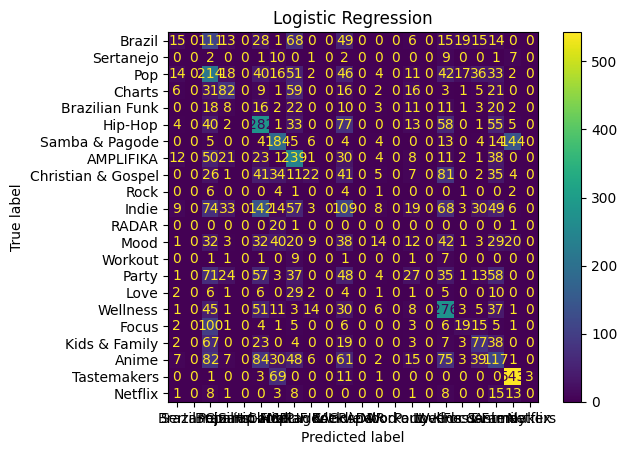

In [ ]:
cm = confusion_matrix(y_val, y_val_pred)

# plot confusion matrix of logistic regression
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("Logistic Regression")
plt.show()

In [ ]:
# AUC
y_val_proba = best_lr_pipeline.predict_proba(X_val)

# roc auc score using one versus rest and macro average
LR_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')
f"The average AUC for the logistic regression model is {LR_auc:0.3f}"

'The average AUC for the logistic regression model is 0.819'

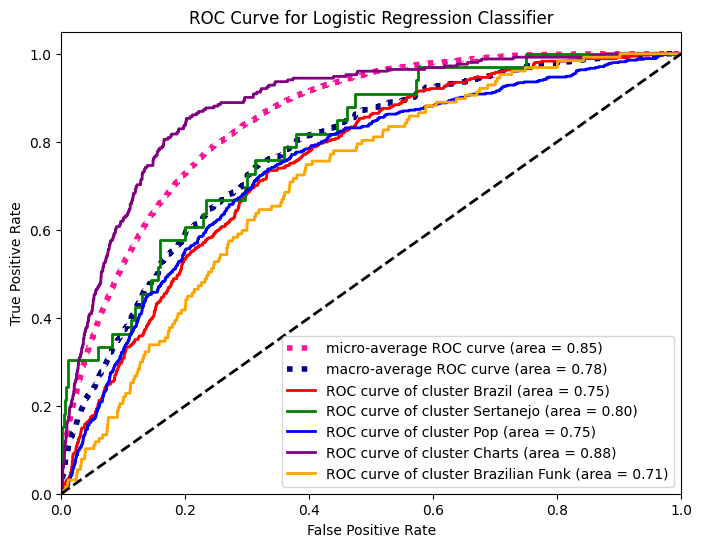

In [ ]:
# Plot ROC Curves for Logistic Regression
from sklearn.preprocessing import label_binarize
from itertools import cycle
# Ensure the classes used in label_binarize match the unique classes in y_val
classes = np.unique(y_val)
y_val_bin = label_binarize(y_val, classes=classes)

n_classes = 5
lw=2

y_score = best_lr_pipeline.decision_function(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Change the colors here
colors = cycle(["red", "green", "blue", "purple", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(target_names[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression Classifier")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# f1 score
from sklearn.metrics import f1_score
LR_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The baseline F1(macro) socre of the logistic regression model on the validation data is {LR_f1:0.3f}"

'The baseline F1(macro) socre of the logistic regression model on the validation data is 0.196'

### 2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline com RandomForestClassifier
pipeline_rf = Pipeline(
    [
        ("scaler", StandardScaler()),  # Escalonar recursos
        ("rf_clf", RandomForestClassifier(random_state=0)),  # Classificador Random Forest
    ]
)

# Defina uma grade de hiperparâmetros para o RandomForestClassifier
param_grid_rf = {
    "rf_clf__n_estimators": [50, 100, 200],              # Número de árvores
    "rf_clf__max_depth": [None, 10, 20, 30],             # Profundidade máxima das árvores
    "rf_clf__min_samples_split": [2, 5, 10],             # Número mínimo de amostras para dividir um nó
    "rf_clf__min_samples_leaf": [1, 2, 4],               # Número mínimo de amostras em uma folha
    "rf_clf__class_weight": [None, "balanced"],          # Ajuste para desbalanceamento
}

# Aplicar o GridSearchCV para o RandomForestClassifier
# grid_search_rf = GridSearchCV(
#     pipeline_rf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
# )

# Ajustar o modelo nos dados de treinamento
# grid_search_rf.fit(X_train, y_train)

# Se você já encontrou os melhores hiperparâmetros, ajuste diretamente o pipeline
best_rf_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("rf_clf", RandomForestClassifier(
            n_estimators=100,              # Ajuste conforme o melhor resultado
            max_depth=None,                 # Ajuste conforme o melhor resultado
            min_samples_split=2,            # Ajuste conforme o melhor resultado
            min_samples_leaf=1,             # Ajuste conforme o melhor resultado
            class_weight=None,              # Ajuste conforme o melhor resultado
            random_state=0
        )),
    ]
)
rf_clf=best_rf_pipeline

# Ajustar o pipeline com os dados de treinamento
best_rf_pipeline.fit(X_train, y_train)

# Agora você pode usar best_rf_pipeline para fazer previsões
# Por exemplo:
# y_pred = best_rf_pipeline.predict(X_test)

# Se você precisar visualizar os resultados ou métricas, pode fazer isso aqui


In [ ]:
print("Best Parameters:", best_rf_params)

Best Parameters: {'rf_clf__bootstrap': True, 'rf_clf__class_weight': None, 'rf_clf__max_depth': 10, 'rf_clf__max_features': 'sqrt', 'rf_clf__max_samples': 0.9, 'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 2, 'rf_clf__n_estimators': 100}


In [ ]:
rf_clf.fit(X_train, y_train)
# make prediction on validation data
y_val_pred = rf_clf.predict(X_val)
# check first 20 ground truths and prediction
print('Actual label:    ', y_val[:20])
print('Predicted label: ', y_val_pred[:20])

Actual label:     ['Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil'
 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil'
 'Brazil' 'Brazil' 'Brazil' 'Brazil']
Predicted label:  ['Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil'
 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil' 'Brazil'
 'Brazil' 'Brazil' 'Brazil' 'Brazil']


In [ ]:
report_2 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_rf = pd.DataFrame(report_2).transpose()
df_r_rf.head()

/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

,precision,recall,f1-score,support
Brazil,0.153846,0.011299,0.021053,354.0
Sertanejo,0.000000,0.000000,0.000000,33.0
Pop,0.210918,0.467033,0.290598,546.0
Charts,0.380117,0.257937,0.307329,252.0
Brazilian Funk,0.000000,0.000000,0.000000,127.0


<Figure size 2000x1200 with 0 Axes>

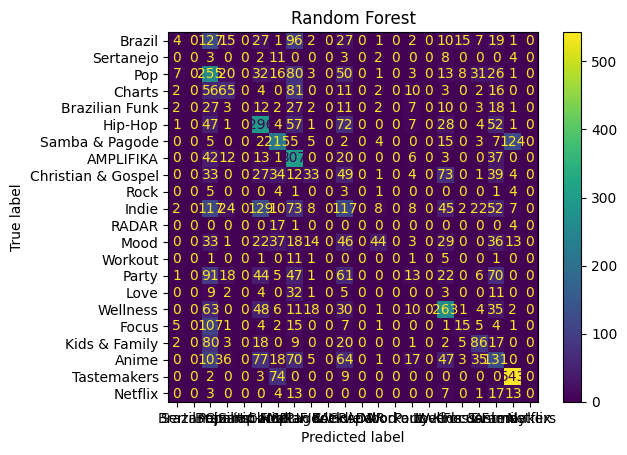

In [ ]:
# plot confusion matrix of random forest model
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("Random Forest")
plt.show()

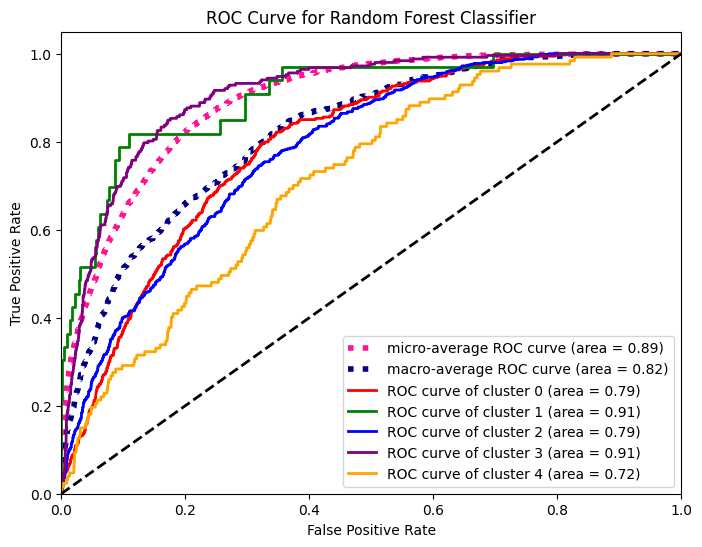

In [ ]:
# Plot ROC for Random Forest Classifier
y_score = best_rf_pipeline.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["red", "green", "blue", "purple", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Classifier")
plt.legend(loc="lower right")
plt.show()

In [ ]:
RF_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The F1(macro) socre of the random forest model on the validation data is {RF_f1:0.3f}"

'The F1(macro) socre of the random forest model on the validation data is 0.213'

### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline com XGBClassifier
pipeline_xg = Pipeline(
    [
        ("scaler", StandardScaler()),  # Escalonar recursos
        ("xg_clf", XGBClassifier(booster="gbtree", use_label_encoder=False, eval_metric="mlogloss", random_state=0)),
    ]
)

# Defina uma grade de hiperparâmetros para o XGBClassifier
param_grid_xg = {
    "xg_clf__n_estimators": [50, 100],              # Número de árvores
    "xg_clf__max_depth": [3, 5, 7],                      # Profundidade máxima das árvores
    "xg_clf__learning_rate": [0.01, 0.05, 0.1],          # Taxa de aprendizado
    "xg_clf__subsample": [0.7, 0.9],                # Proporção de amostras para treinamento
    "xg_clf__colsample_bytree": [0.7, 1.0],         # Proporção de recursos para cada árvore
    "xg_clf__gamma": [0, 0.1, 0.2],                      # Regularização para divisão
    "xg_clf__reg_alpha": [0, 0.1],                       # Regularização L1
}


# Aplicar o GridSearchCV para o XGBClassifier
grid_search_xg = GridSearchCV(
    pipeline_xg, param_grid_xg, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)

# Ajustar o modelo nos dados de treinamento
grid_search_xg.fit(X_train, y_train)

# Melhor estimador e hiperparâmetros encontrados
best_xg_pipeline = grid_search_xg.best_estimator_
best_xg_params = grid_search_xg.best_params_
print("Best Parameters:", best_xg_params)
print("Best Cross-Validated Score:", grid_search_xg.best_score_)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Fit the model
best_xg_pipeline.fit(X_train, y_train_encoded)

# Make prediction on validation data
y_val_pred_encoded = best_xg_pipeline.predict(X_val)

# Decode the predicted labels back to original labels
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Check first 20 ground truths and prediction
print('Actual label:    ', y_val[:10])
print('Predicted label: ', y_val_pred[:10])

In [ ]:
report_3 = classification_report(y_val, y_val_pred, target_names=target_names,output_dict=True)
df_r_xgb = pd.DataFrame(report_3).transpose()
df_r_xgb.head()

/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kali/git/chorano_e_dancando/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

,precision,recall,f1-score,support
Brazil,0.357683,0.516364,0.422619,550.0
Sertanejo,0.466667,0.218750,0.297872,288.0
Pop,0.000000,0.000000,0.000000,126.0
Charts,0.452381,0.142857,0.217143,133.0
Brazilian Funk,0.409894,0.623656,0.494670,372.0


In [ ]:
# plot confusion matrix of XGBoost model
plt.figure(figsize=(20,12))
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.title("XGBoost Model")
plt.show()

In [ ]:
# Plot ROC for Random Forest Classifier
y_score = best_xg_pipeline.predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plot ROC for a specific class
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["red","green","blue","purple","orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of cluster {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Classifier")
plt.legend(loc="lower right")
plt.show()

In [ ]:
XG_f1 = f1_score(y_val, y_val_pred, average='macro')
f"The F1(macro) socre of the XGBoost model on the validation data is {XG_f1:0.3f}"

'The F1(macro) socre of the XGBoost model on the validation data is 0.213'

## Conclusion

In [ ]:
#XG_f1 RF_f1 LR_f1 compare and take the best one
f1_scores = {
    "Logistic Regression": LR_f1,
    "Random Forest": RF_f1,
    "XGBoost": XG_f1
}

best_model = max(f1_scores, key=f1_scores.get)
best_f1 = f1_scores[best_model]
f"The best model is {best_model} with a F1(macro) score of {best_f1:0.3f}"


'The best model is Random Forest with a F1(macro) score of 0.213'